## 1. Study GNNs and Graph Transformers
•	GNN Models: import PyTorch Geometric (PyG), a library specifically designed for GNNs, which enables the handling of graph-structured data. The goal of using PyG is to build graph models capable of learning node and edge embeddings based on the graph structure and features.

•	Graph Transformers: The design of a Graph Transformer (GT) typically requires handling attention mechanisms and possibly temporal data. This will require extending the current model design to include Transformer layers and attention mechanisms, such as self-attention, to allow the model to focus on important relationships in the graph.

## 2. Graph Transformation
•	Relational Data to Graph: The code takes data from CSV or SQL files that include student, course, and enrollment information. It maps this data into a graph structure, where:

o	Nodes represent students and courses.
o	Edges represent enrollments (i.e., which student is enrolled in which course).
•	The code converts the student_id and course_id into categorical codes to create a proper edge index (which defines the relationships between students and courses).
•	Node Features: Student and course features are represented as identity matrices, which means each node is initially described by a unique vector.
## 3. Time-Series Integration
•	Embedding Time-Series Data: integrating time-series data (e.g., student clicks) to track engagement trends. The code prepares for this by padding student node features and appending them to the existing features for students. This would allow you to integrate temporal data later.
•	The time_series_data variable needs to be preprocessed (e.g., normalization or embedding) and embedded into the graph, which is accomplished by adding the new_student_features and padding the course_features.
## 4. Graph Transformer Model Design
•	Model Design: the code sets up the data structure, it doesn't yet implement the full model for processing both relational and temporal data. A Graph Transformer model would need to:
o	Integrate attention mechanisms to capture the importance of different nodes and edges in the graph.
o	Handle temporal data: This can be done by using models like Temporal Graph Networks (TGNs) or similar, which process sequential data and learn temporal dependencies between node features.
•	This model design could be achieved by adding graph transformer layers that attend to both spatial (relational) and temporal features.


Data

In [6]:
import pandas as pd

# Load CSV files
students_df = pd.read_csv(r'C:\Users\David\Downloads\FYP\students.csv')
courses_df = pd.read_csv(r'C:\Users\David\Downloads\FYP\courses.csv')
enrollments_df = pd.read_csv(r'C:\Users\David\Downloads\FYP\enrollments.csv')

# Check the contents of the DataFrames
print(students_df.head())
print(courses_df.head())
print(enrollments_df.head())


   id             name               nationality                 city  \
0   0        Kiana Lor                     China               Suzhou   
1   1   Joshua Lonaker  United States of America        Santa Clarita   
2   2    Dakota Blanco  United States of America              Oakland   
3   3  Natasha Yarusso  United States of America        Castro Valley   
4   4   Brooke Cazares                    Brazil  São José dos Campos   

   latitude  longitude gender  ethnic.group  age  english.grade  math.grade  \
0     31.31     120.62      F           NaN   22            3.5         3.7   
1     34.39    -118.54      M           NaN   22            2.9         3.2   
2     37.80    -122.27      F           NaN   22            3.9         3.8   
3     37.69    -122.09      F           NaN   20            3.3         2.8   
4    -23.18     -45.88      F           NaN   21            3.7         2.6   

   sciences.grade  language.grade  portfolio.rating  coverletter.rating  \
0          

 Import Graph Libraries

In [7]:
# Install libraries (uncomment and run if not already installed)
# !pip install torch torchvision torch-geometric networkx matplotlib

import torch
import torch_geometric as pyg
import networkx as nx
import matplotlib.pyplot as plt


Transform Relational Data into a Graph

Using PYG:

In [18]:
print(enrollments_df.dtypes)

student_id              int32
course_id              object
nationality            object
city                   object
latitude              float64
longitude             float64
gender                 object
ethnic.group          float64
age                     int64
english.grade         float64
math.grade            float64
sciences.grade        float64
language.grade        float64
portfolio.rating        int64
coverletter.rating    float64
refletter.rating        int64
dtype: object


In [20]:
print(enrollments_df['course_id'].unique())

['Kiana Lor' 'Joshua Lonaker' 'Dakota Blanco' 'Natasha Yarusso'
 'Brooke Cazares' 'Rochelle Johnson' 'Joey Abreu' 'Preston Suarez'
 'Lee Dong' "Maa'iz al-Dia" 'Maja Nicholson' 'Sasha Jansen'
 'Alexander Sherman' 'Edgar Sanchez' 'Kolbi Strunk' 'Brittany Sath'
 'Meggan Smith' 'Ericka Arreola' 'David Pulc' 'Kyle Luckey' 'Rojesh Her'
 'David Weber' 'Rachel Jambor' "Mus'ab al-Moustafa" 'Sila Nguyen'
 'Samantha Hicks' 'Angela Harding' 'Brandon Barbour' 'Reilly Wagar'
 'Victoria Ibarra' 'Dakota Wirth' 'Lauren Klocker' 'Michael Benson'
 'Sean Rozga' 'Cody Vermeylen' 'Kinaana al-Jamail' 'Daniel Garcia'
 'Katrina Saito' 'Joshua Galloway' 'Aylin Mendoza' 'Sharon Fyfe'
 'Afnaan el-Mohammed' 'Jesse Williams' 'Kenny Fukushima' 'Tawnie Glaisher'
 'Britany Stevens' 'Alan Trinh' 'Zoe Kern' 'Sidney Beavers'
 'Miriam Aguilar' 'Issac Mata' 'Hannah Uren' 'Zachary Bradley'
 'Moira Buttitto' 'Nicole Humpal' 'Georgia Williams' 'Connor Ferry'
 'Amanda Tatum' 'Cameron Steinberg' 'Shuraih el-Karim' 'Katelyn Shar

In [21]:
enrollments_df['course_id'] = pd.to_numeric(enrollments_df['course_id'], errors='coerce')
enrollments_df = enrollments_df.dropna(subset=['course_id'])
enrollments_df['course_id'] = enrollments_df['course_id'].astype(int)

In [22]:
enrollments_df['course_id'] = pd.Categorical(enrollments_df['course_id']).codes

In [23]:
edge_index = torch.tensor([
    enrollments_df['student_id'].values,
    enrollments_df['course_id'].values
], dtype=torch.long)

In [24]:
from torch_geometric.data import Data

# Create edge index from the enrollments data (source and target nodes)
edge_index = torch.tensor([
    enrollments_df['student_id'].values,
    enrollments_df['course_id'].values
], dtype=torch.long)

# Create node features for students and courses (using identity matrix for simplicity)
student_features = torch.eye(len(students_df))
course_features = torch.eye(len(courses_df))

# Combine node features into a single tensor
x = torch.cat((student_features, course_features), dim=0)

# Create a PyG Data object
data = Data(x=x, edge_index=edge_index)

print(data)


Data(x=[614, 307], edge_index=[2, 0])


Add Attributes

In [28]:
print("student_features shape:", student_features.shape)
print("time_series_data shape:", time_series_data.shape)
print("new_student_features shape:", new_student_features.shape)
print("course_features shape:", course_features.shape)

student_features shape: torch.Size([307, 307])
time_series_data shape: torch.Size([307, 10])
new_student_features shape: torch.Size([307, 317])
course_features shape: torch.Size([307, 307])


In [29]:
# Calculate the number of columns to add
cols_to_add = new_student_features.shape[1] - course_features.shape[1]

# Pad course_features with zeros
padded_course_features = torch.nn.functional.pad(course_features, (0, cols_to_add, 0, 0))

# Now concatenate the tensors
new_x = torch.cat([new_student_features, padded_course_features], dim=0)

# Update the node features in the Data object
data.x = new_x

print("Time-series data added to student nodes.")
print(f"New node feature shape: {data.x.shape}")

Time-series data added to student nodes.
New node feature shape: torch.Size([614, 317])


In [32]:
feature_dict = {
    'original_features': list(range(student_features.shape[1])),
    'time_series': list(range(student_features.shape[1], student_features.shape[1] + 10))
}

print("Feature mapping:", feature_dict)

Feature mapping: {'original_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 

In [33]:
student_time_series = data.x[:len(students_df), feature_dict['time_series']]
print("Shape of student time-series data:", student_time_series.shape)

Shape of student time-series data: torch.Size([307, 10])


Visualize the Graph

Visualization Using pyg and NetworkX:

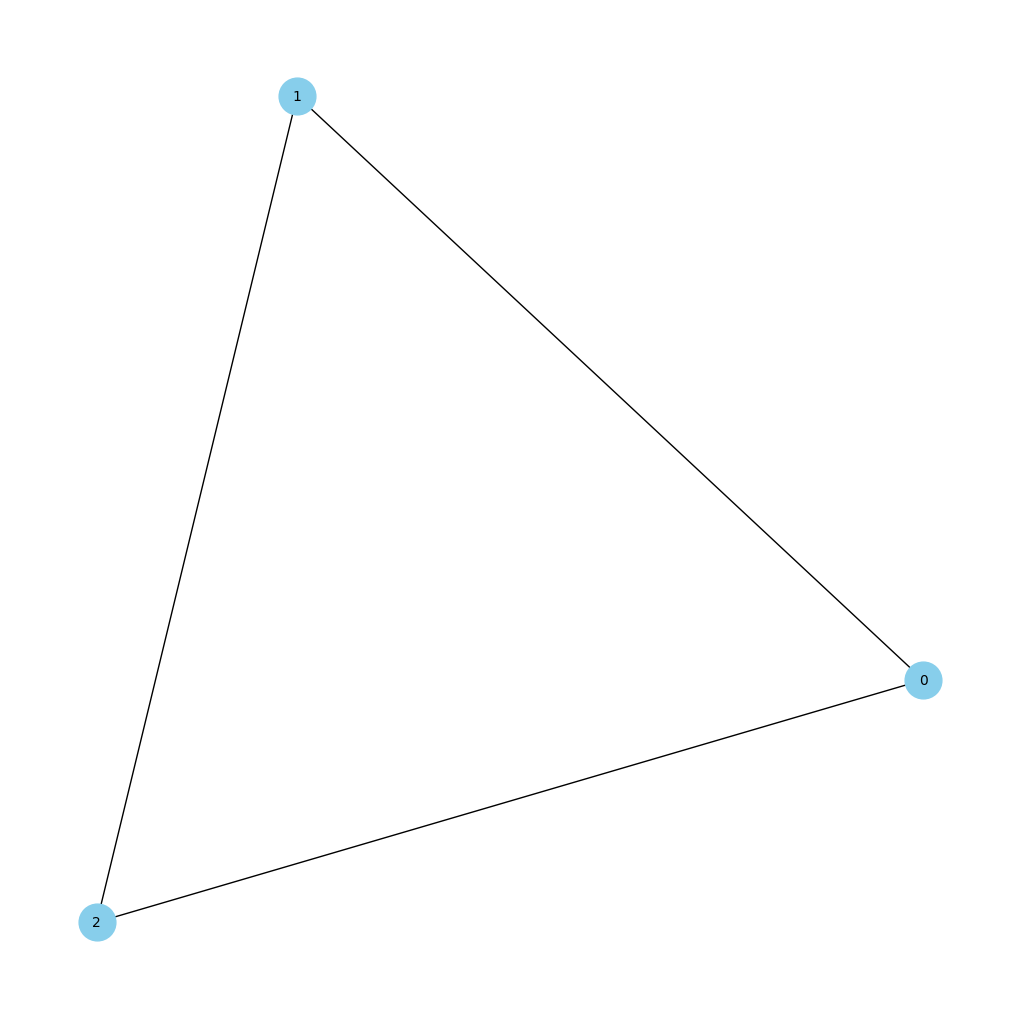

In [11]:
# Convert to NetworkX for visualization
nx_graph = nx.Graph()
nx_graph.add_edges_from(data.edge_index.t().tolist())

# Draw the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color='skyblue', node_size=700, font_size=10)
plt.show()


In [8]:
pip install torch torch-geometric matplotlib networkx


Defaulting to user installation because normal site-packages is not writeable
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached frozenlist-1.5.0-cp39-cp39-win_amd64.whl.metadata (14 kB)
  Using cached multidict-6.1.0-cp39-cp39-win_amd64.whl.metadata (5.1 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
Using cached frozenlist-1.5.0-cp39-cp39-win_amd64.whl (51 kB)
Using cached multidict-6.1.0-cp39-cp39-win_amd64.whl (28 kB)
Note: you may need to restart the kernel to use updated packages.


Evaluate the Initial Transformation

Inspect Nodes and Edges:

In [35]:
# Number of nodes and edges
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")

# Check node features
print("Node features shape:", data.x.shape)


Number of nodes: 614
Number of edges: 0
Node features shape: torch.Size([614, 317])


Verify Relationships:

In [36]:
# Check if a specific student is enrolled in a course
student_id = 1  # Example student_id
course_id = 1  # Example course_id

# Check if there is an edge between student and course
if (student_id, course_id) in data.edge_index.t().tolist():
    print(f"Student {student_id} is enrolled in course {course_id}.")
else:
    print(f"Student {student_id} is not enrolled in course {course_id}.")


Student 1 is not enrolled in course 1.


Advanced Steps (Optional)

Integrate with a Graph Transformer Model:

In [37]:
from torch_geometric.nn import GCNConv
import torch.nn as nn

class SimpleGCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, out_feats)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = SimpleGCN(in_feats=student_features.shape[1], hidden_feats=16, out_feats=2)
print(model)


SimpleGCN(
  (conv1): GCNConv(307, 16)
  (conv2): GCNConv(16, 2)
)


Necessary libraries

In [3]:
# Cell 1: Import necessary libraries
import pandas as pd
import torch
import torch_geometric as pyg
from torch_geometric.data import HeteroData
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GATConv, GCNConv
import matplotlib.pyplot as plt
import networkx as nx

Enrollments if necessary

In [9]:
# Create dummy enrollments if necessary
if 'student_id' not in enrollments_df.columns or 'course_id' not in enrollments_df.columns:
    print("Warning: Enrollment data not found. Creating dummy enrollments.")
    num_students = len(students_df)
    num_courses = len(courses_df)
    dummy_enrollments = [(i, j % num_courses) for i in range(num_students) for j in range(5)]  # Each student enrolls in 5 random courses
    enrollments_df = pd.DataFrame(dummy_enrollments, columns=['student_id', 'course_id'])

# Now create the graph structure
data = HeteroData()

# Add node features
data['student'].x = torch.eye(len(students_df))
data['course'].x = torch.eye(len(courses_df))

# Add edge indices
edge_index = torch.tensor([
    enrollments_df['student_id'].values,
    enrollments_df['course_id'].values
], dtype=torch.long)
data['student', 'enrolled', 'course'].edge_index = edge_index

# Add time-series data to student nodes
time_series_data = torch.stack(click_data['clicks'].tolist())
data['student'].time_series = time_series_data

print("Graph Data:")
print(data)

Graph Data:
HeteroData(
  student={
    x=[307, 307],
    time_series=[307, 10],
  },
  course={ x=[307, 307] },
  (student, enrolled, course)={ edge_index=[2, 1535] }
)


C:\Users\David\AppData\Local\Temp\ipykernel_3208\3214782351.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_index = torch.tensor([


Graph Transformer Model

In [11]:
# Cell 4: Define Graph Transformer Model
class GraphTransformer(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = HeteroConv({
            ('student', 'enrolled', 'course'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
            ('course', 'rev_enrolled', 'student'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
        })
        self.conv2 = HeteroConv({
            ('student', 'enrolled', 'course'): GATConv((hidden_channels, hidden_channels), out_channels, add_self_loops=False),
            ('course', 'rev_enrolled', 'student'): GATConv((hidden_channels, hidden_channels), out_channels, add_self_loops=False),
        })
        self.temporal_conv = torch.nn.Conv1d(10, out_channels, kernel_size=3, padding=1)

    def forward(self, x_dict, edge_index_dict, time_series):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: x.relu() for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        
        # Process temporal data
        temporal_features = self.temporal_conv(time_series.unsqueeze(1)).squeeze(1)
        x_dict['student'] = x_dict['student'] + temporal_features
        
        return x_dict

# Initialize model
model = GraphTransformer(hidden_channels=64, out_channels=32)
print("Model Architecture:")
print(model)

Model Architecture:
GraphTransformer(
  (conv1): HeteroConv(num_relations=2)
  (conv2): HeteroConv(num_relations=2)
  (temporal_conv): Conv1d(10, 32, kernel_size=(3,), stride=(1,), padding=(1,))
)


Visualize the graph

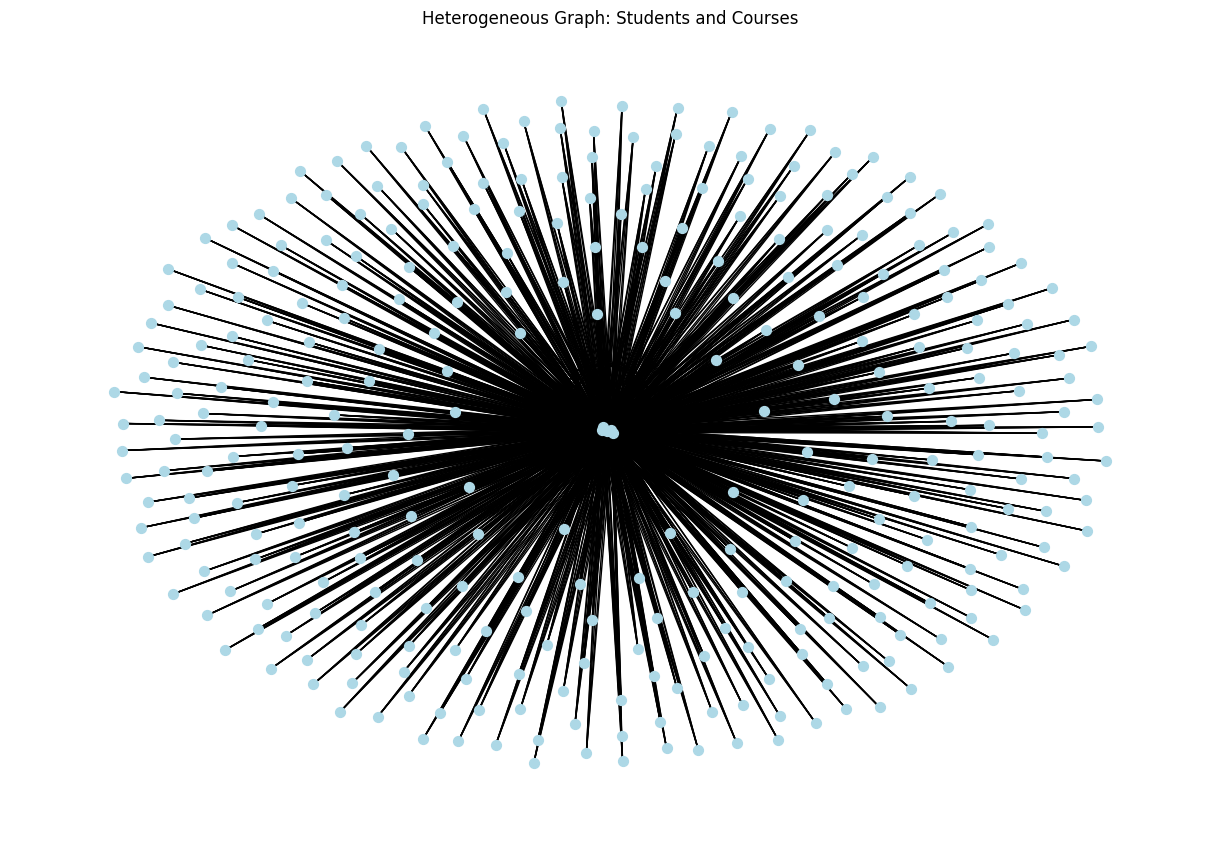

In [12]:
# Cell 5: Visualize the graph
def visualize_graph(data):
    edge_index = data['student', 'enrolled', 'course'].edge_index
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, node_color='lightblue', with_labels=False)
    plt.title("Heterogeneous Graph: Students and Courses")
    plt.show()

visualize_graph(data)

Example forward pass

In [21]:
class GraphTransformer(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_time_steps, num_students):
        super().__init__()
        self.conv1 = HeteroConv({
            ('student', 'enrolled', 'course'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
            ('course', 'rev_enrolled', 'student'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
        })
        self.conv2 = HeteroConv({
            ('student', 'enrolled', 'course'): GATConv((hidden_channels, hidden_channels), out_channels, add_self_loops=False),
            ('course', 'rev_enrolled', 'student'): GATConv((hidden_channels, hidden_channels), out_channels, add_self_loops=False),
        })
        self.temporal_conv = torch.nn.Conv1d(1, out_channels, kernel_size=3, padding=1)
        self.num_time_steps = num_time_steps
        self.linear = torch.nn.Linear(num_time_steps, out_channels)
        self.final_linear = torch.nn.Linear(out_channels, num_students)

    def forward(self, x_dict, edge_index_dict, time_series):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: x.relu() for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        
        # Process temporal data
        batch_size, _ = time_series.shape
        time_series = time_series.view(batch_size, 1, self.num_time_steps)
        temporal_features = self.temporal_conv(time_series)
        temporal_features = self.linear(temporal_features.squeeze(1))
        
        # Adjust dimensions
        student_features = self.final_linear(x_dict['student'])
        temporal_features = self.final_linear(temporal_features)
        
       
        x_dict['student'] = student_features + temporal_features
        
        return x_dict

# Initialize model
num_time_steps = data['student'].time_series.shape[1]  # Should be 10 based on your previous code
num_students = data['student'].x.shape[0]
out_channels = 32  # This should match the dimension of student features after graph convolutions
model = GraphTransformer(hidden_channels=64, out_channels=out_channels, num_time_steps=num_time_steps, num_students=num_students)
print("Model Architecture:")
print(model)

# Example forward pass
x_dict = {'student': data['student'].x, 'course': data['course'].x}
edge_index_dict = {('student', 'enrolled', 'course'): data['student', 'enrolled', 'course'].edge_index}
edge_index_dict[('course', 'rev_enrolled', 'student')] = edge_index_dict[('student', 'enrolled', 'course')].flip([0])

output = model(x_dict, edge_index_dict, data['student'].time_series)
print("Output shape for students:", output['student'].shape)
print("Output shape for courses:", output['course'].shape)

Model Architecture:
GraphTransformer(
  (conv1): HeteroConv(num_relations=2)
  (conv2): HeteroConv(num_relations=2)
  (temporal_conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (linear): Linear(in_features=10, out_features=32, bias=True)
  (final_linear): Linear(in_features=32, out_features=307, bias=True)
)


RuntimeError: The size of tensor a (307) must match the size of tensor b (32) at non-singleton dimension 1